# Dimensionality Reduction

Many machine learning problems involve thousands or even millions of features for each training instance.

Not only this is computationally expensive and extremely slow, but it can also make it much harder to find a good solution.

With real-world problems, it is often possible to reduce the number of features considerably.

Reducing dimensionality causes information loss. It is a generally good practice to first train the system against the original data before considering dimensionality reduction.

While in some cases reducing dimensionality can filter out noise and unnecessary details, resulting in higher performance, in general it will just speed up training.

Dimensionality reduction is also extremely useful for data visualization.

The two main approaches to reducing dimensionality are *projection* and *Manifold Learning*.

## Projection

In most real-world problems, training instances are not spread out uniformly in all dimensions. Many features are almost constant, while others are highly correlated.

As a result, all training instances lie within (or close to) a much lower-dimensional subspace of the high-dimensional space.

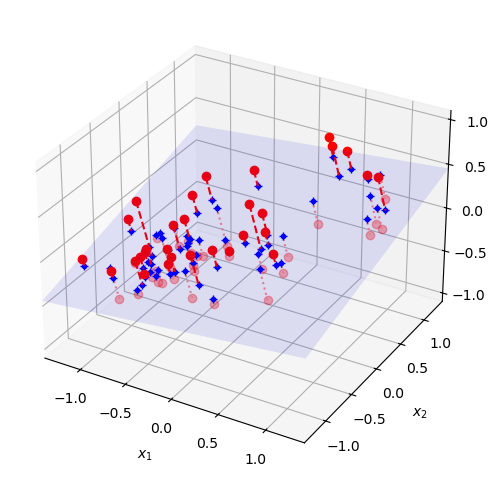

In [3]:
# credit https://github.com/ageron/handson-ml3/blob/main/08_dimensionality_reduction.ipynb

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from sklearn.decomposition import PCA

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected samples
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefs
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")

# plot samples and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # projected samples
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# now plot projection lines and samples above plane
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

plt.show()

The plane is a lower-dimensional subspace that the data lies close to. Projecting every training instance perpendicularly onto this subspace results in a 2D dataset.

The axes correspond to new features z1 and z2: the coordinates of the projections on the plane.

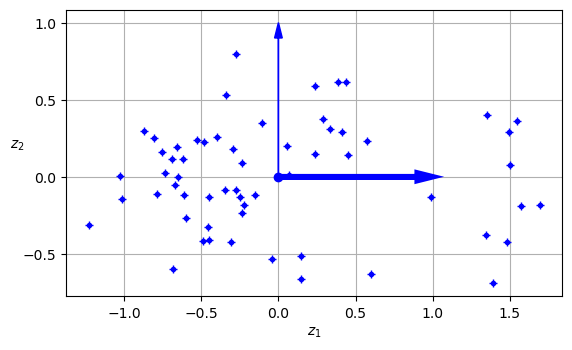

In [4]:
# credit https://github.com/ageron/handson-ml3/blob/main/08_dimensionality_reduction.ipynb
# extra code – this cell generates and saves Figure 8–3

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True)


## Manifold Learning

In many cases, projection may not be the best approach to dimensionality reduction.

The Swiss roll is a classic example of a 2D manifold that cannot be represented on a plane without distortion.

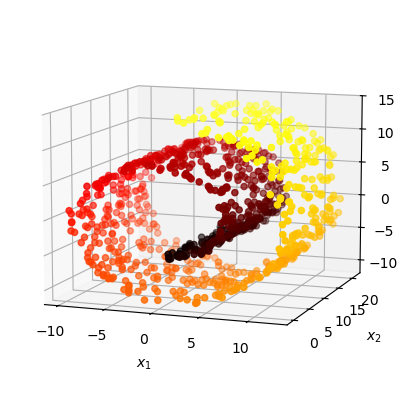

In [5]:
# credit https://github.com/ageron/handson-ml3/blob/main/08_dimensionality_reduction.ipynb

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_swiss_roll

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)



darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes)
plt.show()

If we project the Swiss roll onto a plane,  different layers of the roll are being squashed together:

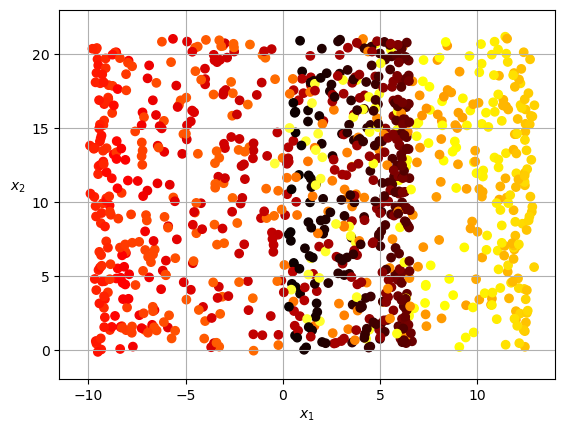

In [12]:
plt.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", labelpad=10, rotation=0)
plt.grid(True)

And here the Swiss roll is unrolled to obtain the 2D dataset.

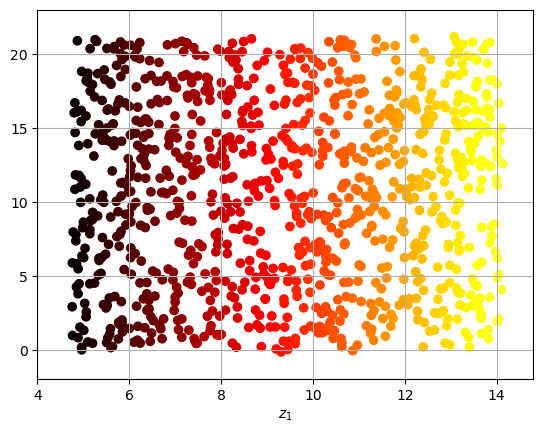

In [15]:
# plt.subplot(121)
# plt.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)
# plt.axis(axes[:4])
# plt.xlabel("$x_1$")
# plt.ylabel("$x_2$", labelpad=10, rotation=0)
# plt.grid(True)

# plt.subplot(122)
plt.scatter(t, X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis([4, 14.8, axes[2], axes[3]])
plt.xlabel("$z_1$")
plt.grid(True)

plt.show()

The Swiss roll is an example of a 2D *manifold*: a 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space.

A d-dimensional manifold is a part of an n-dimensional space (where d < n) that locally resembles a d-dimensional hyperplane.

Many dimensionality reduction algorithms work by modeling the manifold on which the training instances lie; this is called manifold learning.

It relies on the manifold assumption, also called the manifold hypothesis, which holds that most real-world high-dimensional datasets lie close to a much lower-dimensional manifold.

The manifold assumption is often accompanied by another implicit assumption: that the task at hand will be simpler if expressed in the lower-dimensional space of the manifold.

In the example below, the Swiss roll dataset is split into two classes: in the 3D space the decision boundary would be fairly complex, but in the 2D unrolled manifold space the decision boundary is a straight line.

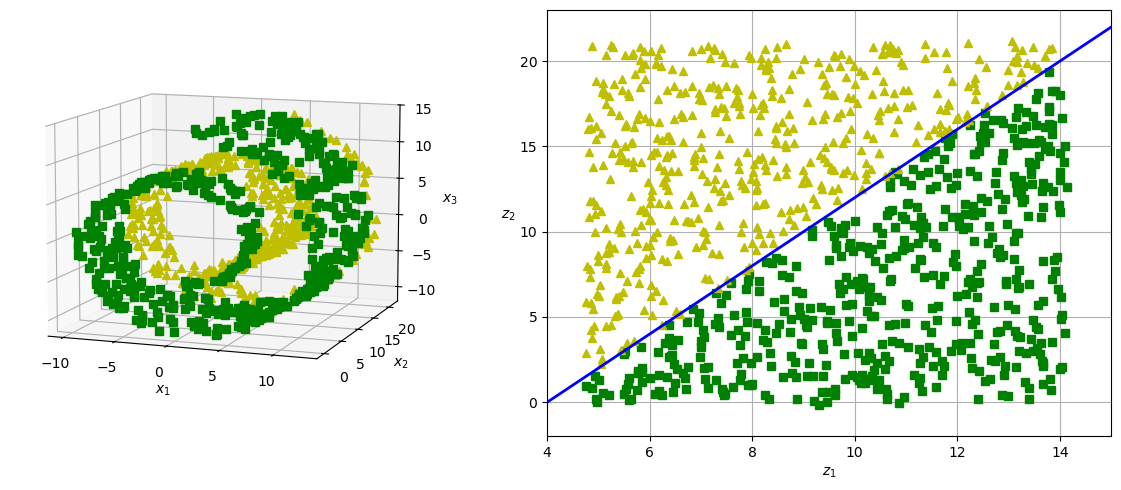

In [67]:
positive_class = 2 * (t[:] - 4) > X_swiss[:, 1]
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

# Create a single figure with two subplots side by side
fig = plt.figure(figsize=(12, 5))

# First subplot (3D plot) on the left
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.view_init(10, -70)
ax1.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax1.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax1.xaxis.set_rotate_label(False)
ax1.yaxis.set_rotate_label(False)
ax1.zaxis.set_rotate_label(False)
ax1.set_xlabel("$x_1$", rotation=0)
ax1.set_ylabel("$x_2$", rotation=0)
ax1.set_zlabel("$x_3$", rotation=0)
ax1.set_xlim(axes[0:2])
ax1.set_ylim(axes[2:4])
ax1.set_zlim(axes[4:6])

# Second subplot (2D plot) on the right
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax2.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax2.plot([4, 15], [0, 22], "b-", linewidth=2)
ax2.axis([4, 15, axes[2], axes[3]])
ax2.set_xlabel("$z_1$")
ax2.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

This assumption does not always hold: in the example below, the decision boundary is located at $x_1 = 5$ in the 3D space, but in the 2D unrolled manifold space it is a more complex curve.

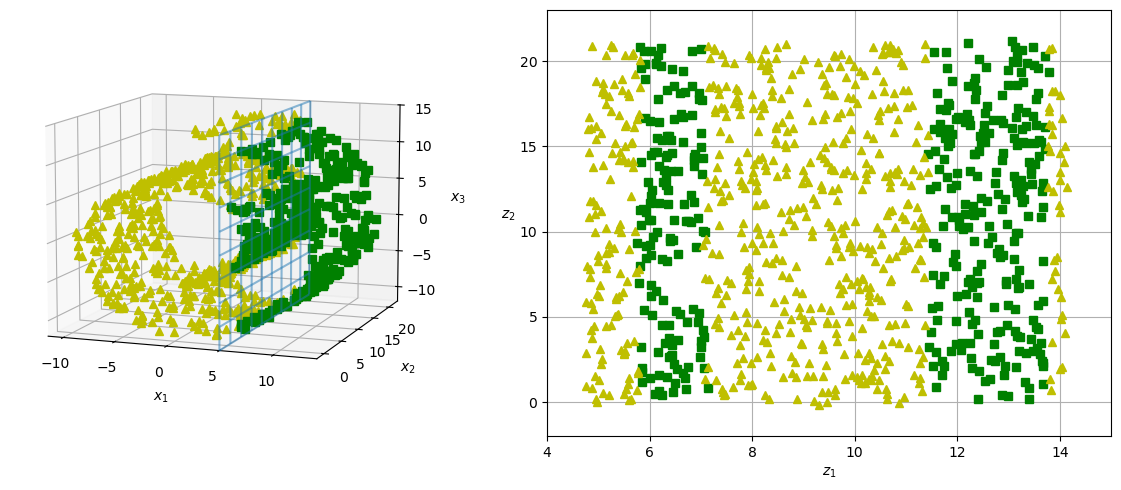

In [69]:
axes = [-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

positive_class = X_swiss[:, 0] > 5
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

# Create a single figure with two subplots side by side
fig = plt.figure(figsize=(12, 5))

# First subplot (3D plot) on the left
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.view_init(10, -70)
ax1.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax1.plot_wireframe(5, x2, x3, alpha=0.5)
ax1.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
set_xyz_axes(ax1, axes)

# Second subplot (2D plot) on the right
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax2.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax2.axis([4, 15, axes[2], axes[3]])
ax2.set_xlabel("$z_1$")
ax2.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax2.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Dimensionality Reduction Algorithms

The most popular dimensionality reduction algorithms is Principal Component Analysis (PCA), which will be discussed in detail in [the next notebook](project/063-principal-component-analisys.ipynb).

### Random Projection

The random projection algorithm projects the data to a lower-dimensional space using a random linear projection.

The Johnson-Lindenstrauss lemma states that a set of points in a high-dimensional space can be projected to a lower-dimensional space while preserving the distances between the points.

As a result, two similar instances will remain similar after the projection, and two different instances will remain different.

To determine the minimum number of dimensions required to preserve in order to ensure, with high probability, that the distance between the points will not change by more than a given tolerance ε, the following formula can be used:

- $m$ is the number of instances in the dataset with $n$ number of features in each instance
- $d$ is the original number of dimensions
- $\epsilon$ is the tolerance

$$d \geq \cfrac{4 \log(m)}{(\cfrac{{{\epsilon^2}}}{2}-
\cfrac{{\epsilon^3}}{3})}.$$

The equation relies on $m$ and $\epsilon$ and does not use $n$ to determine $d$.

With sklearn, the `sklearn.random_projection` module can be used to perform random projection.


In [80]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
m, tolerance = 5000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=tolerance)
d

np.int64(7300)

Now we *could* generate a random matrix P of shape $[d,n]$, where each item is sampled randomly from a Gaussian distribution with mean $0$ and variance $\frac{1}{d}$, to project the dataset from $n$ dimensions down to $d$ dimensions... or just use the `GaussianRandomProjection` class from sklearn.

In [81]:
from sklearn.random_projection import GaussianRandomProjection
n = 20000
np.random.seed(42)
X = np.random.rand(m, n)

random_projection = GaussianRandomProjection(eps=tolerance, random_state=42)
X_reduced = random_projection.fit_transform(X)
X_reduced.shape

(5000, 7300)

For reference, here's the code to generate the random matrix P and project the dataset manually, but sklearn is much more efficient.

```python
#P = np.random.normal(size=(d, n)) / np.sqrt(d)
# X_manually_reduced = X.dot(P.T)
# X_manually_reduced.shape
```



Another random projection transformation is the `SparseRandomProjection` class. It generates a sparse random matrix, which consumed less memory and is significantly faster to compute.

99% of the time, I use a laptop rather than my desktop when I need to focus: less distractions, with decent performance for what I'm doing (and less power consumption): time wise, the `GaussianRandomProjection` cell took 19.464 seconds to run, while `SparseRandomProjection` took 8.895 seconds.

In [82]:
from sklearn.random_projection import SparseRandomProjection

sparse_random_projection = SparseRandomProjection(eps=tolerance, random_state=42)
X_reduced = sparse_random_projection.fit_transform(X)
X_reduced.shape

(5000, 7300)

### Locally Linear Embedding (LLE)

LLE is a *nonlinear dimensionality reduction* manifold learning technique that does not rely on projections.

LLE works by first measuring how each training instance linearly relates to its nearest neighbors, and then looking for a low-dimensional representation of the training set where these local relationships are best preserved.

This helps when there is a lot of noise in the twisted manifold dataset.

In [83]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

The variable *t* is a 1D NumPy array containing the position of each instance along the rolled axis of the Swiss roll. We don’t use it in this example, but it can be used as a target for a nonlinear regression task.

Distances are not preserved on a larger scale: the unrolled Swiss roll should be a rectangle, not this kind of stretched and twisted band. Nevertheless, LLE did a pretty good job of modeling the manifold.



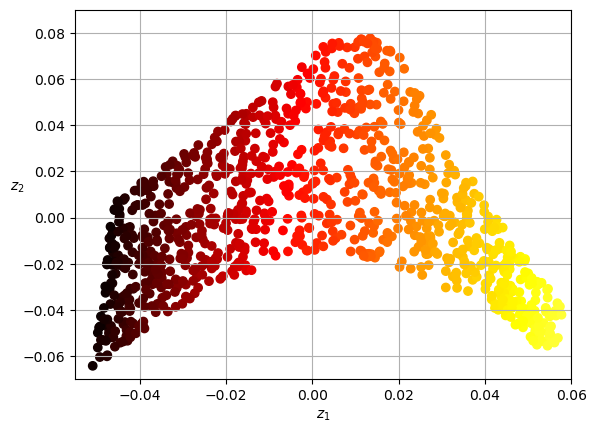

In [86]:
plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)
plt.show()

Here you can see the correlation between z1 and t:

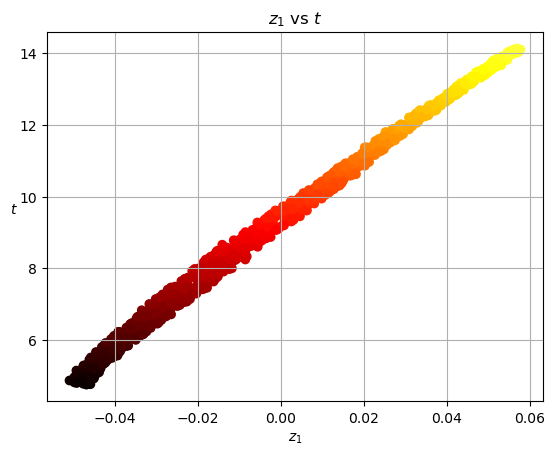

In [87]:
plt.title("$z_1$ vs $t$")
plt.scatter(X_unrolled[:, 0], t, c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$t$", rotation=0)
plt.grid(True)
plt.show()

### Other Dimensionality Reduction Techniques
**Multidimensional Scaling (MDS)**: reduces dimensionality while trying to preserve the distances between the instances.

Works better than random projection for low-dimensional data.


In [88]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, normalized_stress=False, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

**Isomap**: creates a graph by connecting each instance to its nearest neighbors, then reduces dimensionality while trying to preserve the number of nodes along the shortest path between instances (*geodesic distance*).

In [89]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

**t-Distributed Stochastic Neighbor Embedding (t-SNE)**: reduces dimensionality while trying to keep similar instances close and dissimilar instances apart.

It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space.

In [90]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

**Linear Discriminant Analysis (LDA)**: a classification algorithm that reduces dimensionality while preserving as much of the class discrimination information as possible.

These axes can then be used to define a hyperplane onto which to project the data. The benefit of this approach is that the projection will keep classes as far apart as possible, so LDA is a good technique to reduce dimensionality before running another classification algorithm (unless LDA alone is sufficient).

In [94]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Convert continuous t values to discrete class labels
t_discrete = np.digitize(t, bins=np.linspace(min(t), max(t), 5))

lda = LinearDiscriminantAnalysis(n_components=2)
X_reduced_lda = lda.fit_transform(X_swiss, t_discrete)

Here's a visual representation of the four techniques using the Swiss roll dataset:

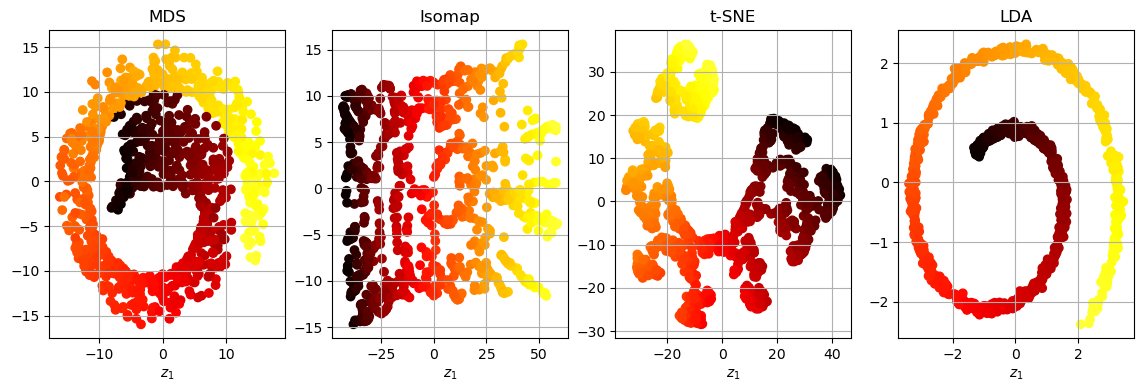

In [101]:
titles = ["MDS", "Isomap", "t-SNE", "LDA"]

plt.figure(figsize=(14, 4))

for subplot, title, X_reduced in zip((141, 142, 143, 144), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne, X_reduced_lda)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)

plt.show()